In [29]:
import os, sys
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import preprocessing
import func_SPI, utils, h5py, plotting
path_obs_data = '/data/volume_2/observational/'
filename = 'chrips_precip_1981-2021.nc'
path_tp = os.path.join(path_obs_data, 'raw', filename)

In [30]:
# load intervals and target periods from EC46 initialization dates
dfs = pd.read_hdf('/data/volume_2/subseasonal/ecmwf/aggregated/aggregation_timestamps.h5').sort_index()
df = dfs[['aggregation_start_inclusive', 'aggregation_end_inclusive']].copy()
sel_months = [10, 11, 12]
mon_start_mask = [True if m in sel_months else False for m in df.set_index('aggregation_start_inclusive').index.month]
mon_end_mask = [True if m in sel_months else False for m in df.set_index('aggregation_end_inclusive').index.month]
mon_mask = np.logical_and(mon_start_mask, mon_end_mask)

In [31]:
tp = xr.open_dataarray(path_tp)
# select region
tp = tp.sel(latitude=slice(-5,8), longitude=slice(38,53))
# spatial mean
tp_sm = tp.mean(dim=('latitude', 'longitude'))
tp_sm

<xarray.DataArray 'precip' (time: 14975)>
array([0.0000000e+00, 4.8481959e-01, 2.6115529e-02, ..., 4.2302564e-01,
       4.3223627e-02, 4.4919315e-04], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2021-12-31

In [65]:
# 28-day rolling mean, center aligned labels, but shifting -14 days to make it left aligned
tp_rm = tp_sm.rolling({'time':28}, min_periods=1, center=True).mean().shift({'time':-14})
tp_rm[-14:] = tp_sm[:14].values
tp_rm

<xarray.DataArray 'precip' (time: 14975)>
array([0.07517769, 0.07538637, 0.06126449, ..., 0.        , 0.        ,
       0.        ])
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2021-12-31

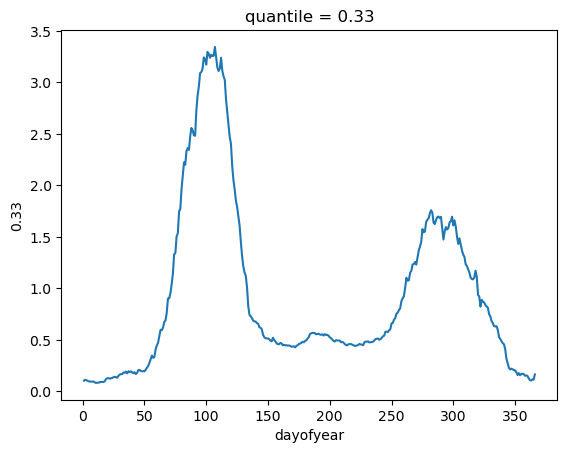

In [66]:
quantiles = tp_rm.groupby(tp_rm.time.dt.dayofyear).quantile(q=.33, dim='time', skipna=True)
quantiles.name = '0.33'
quantiles.plot()

In [67]:
tp_tercile = (tp_rm.groupby(tp_rm.time.dt.dayofyear) < quantiles).astype(int).drop('dayofyear').drop('quantile')

In [68]:
ds = tp_tercile.to_dataset(name='binary')
ds['tp_28d_rm'] = tp_rm
ds['quantile'] = quantiles
ds['spatial_mean_raw'] = tp_sm

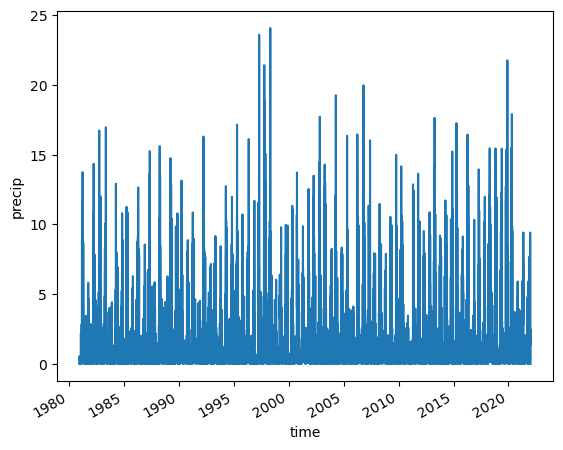

In [69]:
tp_sm.plot()

In [72]:
ds.to_netcdf(os.path.join(path_obs_data, 'chrips_1981-2021_target_new_left.nc'))

Plotting Corr maps precip, split 0, lag 0


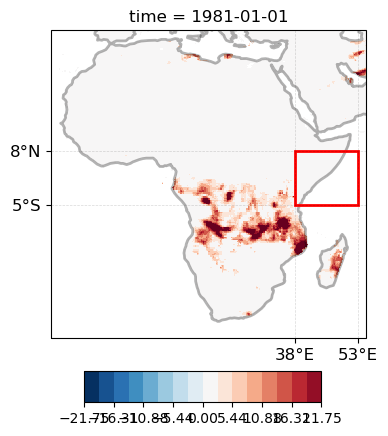

In [73]:
import plotting
from matplotlib.patches import Rectangle
tp = xr.open_dataarray(path_tp)
# Set the parameters required by the drawing function 
box = [38, 53, -5, 8]
fg = plotting.plot_maps(tp[0],  size=4, x_ticks=np.array(box[:2]), y_ticks=box[2:], cbar_vert=-0.1)
ax = fg.fig.axes[0]


scale = '50m'
xstep, ystep = 2, 2
cmap=plt.get_cmap('jet',9)#'RdYlBu_r' 'viridis'
proj=plotting.ccrs.PlateCarree(central_longitude=180)
box_top = 2
lon = tp.longitude.values
lat = tp.latitude.values
# Set the starting point of the rectangle 
start_point = (38, -5)
# Draw 
# # #=============================== Start drawing ==============================
# # # select Rectangular area 
RE=Rectangle(start_point,box[1]-box[0],box[3]-box[2],linewidth=2,linestyle='-' ,zorder=2,\
edgecolor='red',facecolor='none', transform=plotting.ccrs.PlateCarree()) #2
ax.add_patch(RE)


Attempt to standardize below.

Plotting Corr maps precip, split 0, lag 0


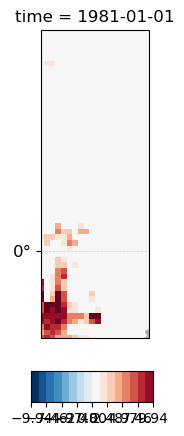

In [3]:
# tp = xr.open_dataarray(path_tp)
# # select region
# tp_region = tp.sel(latitude=slice(-4,10), longitude=slice(35,40))
# fg = plotting.plot_maps(tp_region[0],  size=4, cbar_vert=-0.1)

# aggr = 1
# path_spi = filename.split('_')[0] + f'_SPI_{aggr}_' + '_'.join(filename.split('_')[2:])
# output = func_SPI.calc_SPI_from_daily(tp_region, aggr)



In [ ]:
# output.to_netcdf(os.path.join(path_obs_data, 'preprocessed', path_spi))

In [ ]:
# latitude = 0 ; longitude=30
# ts_raw = tp.to_array().sel(latitude=latitude, longitude=longitude, method='nearest')
# ts_stn = output.sel(latitude=latitude, longitude=longitude, method='nearest')
# # ts_pack = SMI_package.sel(latitude=40, longitude=240)

# fig = plt.figure(figsize=(20,10) )

# # plot observed versus corresponding Gamma probability
# ax1 = plt.subplot(1, 2, 1)
# vals = ax1.plot(ts_raw, '.k');
# # ax1.set_ylabel('Cumulative probability (from Gamma distribution)')
# # ax1.set_xlabel('Aggregated Precipitation [mm] - Original values')
# # plot transformed standard normal from Gamma probability
# ax1 = plt.subplot(1, 2, 2)
# vals = ax1.plot(ts_stn, '.k');
# # ax1.plot(ts_pack, '.r')
# # ax1.set_ylabel('Cumulative probability (from Gamma distribution)')
# ax1.set_xlabel('SPI - Gamma prob. transformed to standard normal ')